In [1]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

In [2]:
from __future__ import print_function, division

import time
import os
import copy

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from tqdm import tqdm
from skimage import io, transform

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
from torch.utils.data import DataLoader, Dataset

import torchvision
from torchvision import datasets, models, transforms, utils

cudnn.benchmark = True
plt.ion()   # interactive mode

import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [3]:
# path constants
path_to_folder = 'Assignment3_Massaged_Data'
train_images_folder = 'train_set_edges'
test_images_folder = 'test_set_luma'
path_to_train_images= path_to_folder + '/' + train_images_folder
path_to_test_images = path_to_folder + '/' + test_images_folder

path_to_train_labels= path_to_folder + '/' + 'train_labels.csv'

In [4]:
image_size = (227, 227)

In [5]:
data_transforms = {
    'train': transforms.Compose([
        transforms.ToTensor()
    ]),
    'test': transforms.Compose([
        transforms.ToTensor()
    ]),
}

In [6]:
class DatasetCustom(Dataset):
    
    def __init__(self, root_dir, csv_path, transform=None):
        self.root = root_dir
        self.dataframe = pd.read_csv(csv_path)
        self.transform = transform
        
    def __len__(self):
        return self.dataframe.shape[0]-1
    
    def __getitem__(self, index):
        if torch.is_tensor(index):
            index = index.tolist()
        img_name = os.path.join(self.root,
                                self.dataframe.iloc[index, 0])
        
        # Added, since my images are in black and white (luma edges)
        image = io.imread(img_name)
        
        
        label1 = (self.dataframe.iloc[index, 1])
        label2 = (self.dataframe.iloc[index, 2])
        
        if self.transform is not None:
            image = self.transform(image)
            
        return image, label1, label2

In [7]:
train_dataset = DatasetCustom(path_to_train_images, path_to_train_labels, transform=data_transforms['train'])

In [8]:
dataloader = DataLoader(train_dataset, batch_size=12,
                        shuffle=True, num_workers=0)

# Show some training images

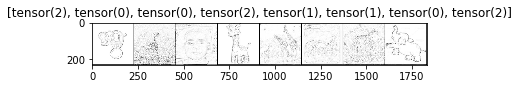

In [9]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated
    
inputs, label1, label2 = next(iter(dataloader))
out = utils.make_grid(inputs[0:8])
imshow(out, title=[x for x in label1[0:8]])


# GPU availability

In [10]:
cuda_available = torch.cuda.is_available()
device = torch.device("cuda:0" if cuda_available else "cpu")
device

device(type='cuda', index=0)

# Training loop function

In [11]:
gamma = 10

def train_model(model, criterion, optimizer, num_epochs=25):    
    since = time.time()

    best_feature_wts = copy.deepcopy(model.feature_extractor.state_dict())
    best_domain_wts = copy.deepcopy(model.domain_classifier.state_dict())
    best_label_wts = copy.deepcopy(model.label_predictor.state_dict())

    best_label_acc = 0.0

    for epoch in range(num_epochs):
        print(f'\nEpoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.feature_extractor.train()  # Set model to training mode
                model.domain_classifier.train()
                model.label_predictor.train()
            else:
                model.feature_extractor.eval()  # Set model to training mode
                model.domain_classifier.eval()
                model.label_predictor.eval()

            # epoch constants
            start_steps = epoch * len(dataloader.dataset)
            total_steps = num_epochs * len(dataloader.dataset)
            running_feature_loss = 0.0
            running_domain_loss = 0.0
            running_label_loss = 0.0
            running_domain_corrects = 0
            running_label_corrects = 0

            # Iterate over data.
            for batch_idx, (inputs, label1s, label2s) in enumerate(tqdm(dataloader)):
                # batch constants
                inputs = inputs.to(device)
                label1s = label1s.to(device)
                label2s = label2s.to(device)

                # setup hyperparameters
                p = float(batch_idx + start_steps) / total_steps
                lambd = round(2. / (1. + np.exp(-gamma * p)) - 1, 3)
                lr = 0.01 / (1. + 10 * p)**0.75
                
                # update lambda and learning rate
                model.domain_classifier.set_lambda(lambd)
                optimizer.feature.lr = lr
                optimizer.domain.lr = lr
                optimizer.label.lr = lr

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):

                    # 1) train feature_extractor and label_predictor
                    
                    # reset gradients
                    model.feature_extractor.zero_grad()
                    model.label_predictor.zero_grad()

                    # get labels
                    feature_vector = model.feature_extractor(inputs).view(inputs.size(0), -1)
                    label_output = model.label_predictor(feature_vector)

                    # get loss and optimize if training
                    if phase == 'train':
                        label_loss = criterion.label(label_output, label2s)    
                        label_loss.backward(retain_graph=True)
                        optimizer.label.step()
                        optimizer.feature.step()
                    

                    # 2) train feature_extractor and domain_classifier
                    
                    # reset gradients
                    model.feature_extractor.zero_grad()
                    model.domain_classifier.zero_grad()

                    # get labels
                    feature_vector = model.feature_extractor(inputs).view(inputs.size(0), -1)
                    domain_output = model.domain_classifier(feature_vector)

                    # get loss and optimize if training
                    if phase == 'train':
                        domain_loss = criterion.domain(domain_output, label1s)    
                        domain_loss.backward(retain_graph=True)
                        optimizer.domain.step()
                        optimizer.feature.step()
                               

                    _, domain_preds = torch.max(domain_output, 1)
                    _, label_preds = torch.max(label_output, 1)

                # statistics
                # running_feature_loss += loss.item() * inputs.size(0)
                running_domain_loss += domain_loss.item() * inputs.size(0)
                running_label_loss += label_loss.item() * inputs.size(0)

                running_domain_corrects += torch.sum(domain_preds == label1s.data)
                running_label_corrects += torch.sum(label_preds == label2s.data)
                

            # epoch_feature_loss = running_feature_loss / len(dataloader.dataset)
            epoch_domain_loss = running_domain_loss / len(dataloader.dataset)
            epoch_label_loss = running_label_loss / len(dataloader.dataset)
            epoch_domain_acc = running_domain_corrects.double() / len(dataloader.dataset)
            epoch_label_acc = running_label_corrects.double() / len(dataloader.dataset)

            # print(f'{phase} Feature_Loss: {epoch_feature_loss:.4f}')
            print(f'{phase} Domain_Loss: {epoch_domain_loss:.4f} Domain_Acc: {epoch_domain_acc:.4f}')
            print(f'{phase} Label_Loss: {epoch_label_loss:.4f} Label_Acc: {epoch_label_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_label_acc > best_label_acc:
                best_label_acc = epoch_label_acc
                best_feature_wts = copy.deepcopy(model.feature_extractor.state_dict())
                best_domain_wts = copy.deepcopy(model.domain_classifier.state_dict())
                best_label_wts = copy.deepcopy(model.label_predictor.state_dict())


    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_label_acc:4f}')

    # load best model weights
    model.feature_extractor.load_state_dict(best_feature_wts)
    model.domain_classifier.load_state_dict(best_domain_wts)
    model.label_predictor.load_state_dict(best_label_wts)
    return model

# Model selection

In [12]:
import torch.nn.functional as F
from torch.autograd import Function

# custom layer to reverse gradient
class GradReverse(Function):
    def __init__(self, lambd):
        self.lambd = lambd

    def forward(self, x):
        return x.view_as(x)

    def backward(self, grad_output):
        return (grad_output * -self.lambd)

def grad_reverse(x, lambd):
    return GradReverse(lambd).apply(x)

# need to make a custom domain classifier class, because the lambda and learning rate are changing
class dann_domain_clf(nn.Module):
    def __init__(self):
        super(dann_domain_clf, self).__init__()
        self.fc1 = nn.Linear(145200, 100) 
        self.fc2 = nn.Linear(100, 3)
        self.drop = nn.Dropout2d(0.25)

    def set_lambda(self, lambd):
        self.lambd = lambd
        
    def forward(self, x):
        x = grad_reverse(x, self.lambd)
        x = F.leaky_relu(self.drop(self.fc1(x)))
        x = self.fc2(x)
        return F.softmax(x, dim=1)

class DANN_Model:
    feature_extractor: object
    domain_classifier: object
    label_predictor: object

In [13]:
# set up Feature Extractor CNN
feature_extractor = nn.Sequential(
    nn.Conv2d(1, 32, kernel_size=5, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2, stride=2),
    nn.Conv2d(32, 48, kernel_size=5, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2, stride=2)
)

# feature_extractor = nn.Sequential(
#     nn.Conv2d(1, 96, kernel_size=5, stride=1, padding=1),
#     nn.ReLU(inplace=True),
#     nn.MaxPool2d(2, stride=2),
#     nn.Conv2d(96, 144, kernel_size=3, stride=1, padding=1),
#     nn.ReLU(inplace=True),
#     nn.MaxPool2d(2, stride=2),
#     nn.Conv2d(144, 256, kernel_size=5, stride=1, padding=1),
#     nn.ReLU(inplace=True),
#     nn.MaxPool2d(2, stride=2),
# )

# set up Domain Classifier MLP
domain_classifier  = dann_domain_clf()

# set up Label Predictor MLP
label_predictor  = nn.Sequential(
    nn.Linear(145200, 100),
    # nn.Linear(1200, 100),
    # nn.Dropout2d(0.2),
    nn.ReLU(),
    nn.Linear(100, 100),
    # nn.Dropout2d(0.2),
    nn.ReLU(),
    nn.Linear(100, 7),
    nn.Softmax(dim=1)
)

# put to device
feature_extractor = feature_extractor.to(device)
domain_classifier = domain_classifier.to(device)
label_predictor = label_predictor.to(device)

model_ft = DANN_Model()
model_ft.feature_extractor = feature_extractor
model_ft.domain_classifier = domain_classifier
model_ft.label_predictor = label_predictor

# Loss function

In [14]:
class DANN_Criterion:
    domain: object
    label: object

criterion = DANN_Criterion()
criterion.domain = nn.CrossEntropyLoss()
criterion.label = nn.CrossEntropyLoss()

# Optimizer and Scheduler

In [15]:
lr = 0.001
momentum = 0.9

class DANN_Optimizer:
    feature: object
    domain: object
    label: object

# Observe that all parameters are being optimized
optimizer_ft = DANN_Optimizer()
optimizer_ft.feature = optim.SGD(model_ft.feature_extractor.parameters(), lr=lr, momentum=momentum)
optimizer_ft.domain = optim.SGD(model_ft.domain_classifier.parameters(), lr=lr, momentum=momentum)
optimizer_ft.label = optim.SGD(model_ft.label_predictor.parameters(), lr=lr, momentum=momentum)

# Decay LR by a factor of 0.1 every 7 epochs
# exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

# Training

In [16]:
model_ft = train_model(model_ft, criterion, optimizer_ft, num_epochs=10)


Epoch 0/9
----------


  0%|          | 0/506 [00:00<?, ?it/s]

0.0


/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
  0%|          | 0/506 [00:00<?, ?it/s]

0.0


AttributeError: 'GradReverseBackward' object has no attribute 'lambd'

# Test data loader

In [ ]:
class TestDatasetCustom(Dataset):
    
    def __init__(self, root_dir, transform=None):
        import glob
        self.root = root_dir
        files = glob.glob(root_dir+'/*.jpg')
        self.files = [root_dir + '/' + str(i) + '.jpg' for i in range(len(files))]
        self.transform = transform
    
    def file_getter(self):
        return self.files
        
    def __len__(self):
        return len(self.files)
    
    def __getitem__(self, index):
        
        if torch.is_tensor(index):
            index = index.tolist()
        
        edges_mask = io.imread(self.files[index])
        
        # Added, since my images are in black and white (luma edges)
        image = np.zeros((edges_mask.shape[0], edges_mask.shape[1], 3))
        image[:,:,0] = edges_mask
        image[:,:,1] = edges_mask
        image[:,:,2] = edges_mask
        image = image.astype(np.uint8)
        
        if self.transform is not None:
            image = self.transform(image)
            
        img_name = self.files[index].split('/')[-1]
            
        return img_name, image

In [ ]:
# test_dir = "/kaggle/input/classification-of-an-out-of-distribution-dataset/test_set/test_set"
test_dataset = TestDatasetCustom(path_to_test_images, transform=data_transforms['train'])

In [ ]:
test_dataloader = DataLoader(test_dataset, batch_size=1,
                        shuffle=False, num_workers=0)

# Saving the result

  0%|          | 0/3929 [00:00<?, ?it/s]

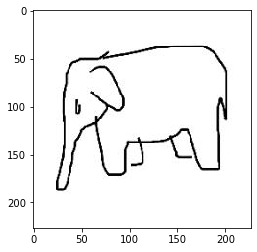

  0%|          | 6/3929 [00:00<03:32, 18.50it/s]

tensor([[1.7387e-08, 7.5716e-11, 1.0663e-06, 9.9680e-01, 6.4027e-10, 2.9250e-08,
         3.2026e-03]])


  0%|          | 10/3929 [00:00<02:38, 24.66it/s]

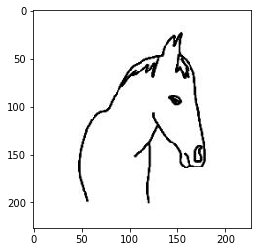

  0%|          | 17/3929 [00:00<02:51, 22.77it/s]

tensor([[2.0034e-07, 1.1155e-09, 5.0760e-06, 9.8228e-01, 1.1325e-08, 3.9769e-07,
         1.7710e-02]])


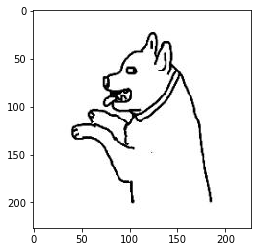

  1%|          | 25/3929 [00:01<02:53, 22.51it/s]

tensor([[1.7523e-07, 4.9961e-10, 3.7914e-06, 9.7802e-01, 3.0585e-09, 1.7984e-07,
         2.1976e-02]])


100%|██████████| 3929/3929 [01:49<00:00, 35.84it/s]


In [ ]:
total = 0
empty_dictionary = {'id': np.zeros((len(test_dataloader))), 'label': np.zeros((len(test_dataloader)))}
predicted_df = pd.DataFrame(data=empty_dictionary)
predicted_df['id'] = predicted_df['id'].apply(str)
predicted_df['label'] = predicted_df['label'].astype(int)
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for index, values in enumerate(tqdm(test_dataloader)):
        # calculate outputs by running images through the network
        image = values
        image_name = image[0]
        image_file = image[1]
        image_file = image_file.cpu().float()
        feature_extractor = model_ft.feature_extractor.cpu()
        domain_classifier = model_ft.domain_classifier.cpu()
        label_predictor = model_ft.label_predictor.cpu()

        feature_vector = feature_extractor(image_file)
        output = label_predictor(feature_vector)
        
        _, predicted = torch.max(output.data, 1)
        
        if index==1 or index==10 or index==20:
            out = torchvision.utils.make_grid(image_file)
            imshow(out)
            print(output)
        
        predicted_df.at[index,'id'] = image_name[0].replace('jpg', 'png')
        predicted_df.at[index,'label'] = str(predicted.numpy()[0])
        

In [ ]:
predicted_df.to_csv('rochi_15-04-2022_8.csv', index = False)